In [1]:
import numpy as np
import os
import random, shutil
import glob

import warnings
warnings.simplefilter('ignore')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from matplotlib.image import imread

from os import makedirs,listdir
from shutil import copyfile
from random import seed
from random import random
import keras 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics

In [2]:
img_rows, img_cols = 150, 150
batch_size = 64
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'Cat-Dog-Dataset/training_set/'
path_test = 'Cat-Dog-Dataset/test_set/'
input_shape = (img_rows, img_cols, 3) #RGB
labels = ['cats', 'dogs']
seed = 10

In [3]:
# Create ImageDataGenerators for training and validation and testing
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [4]:
# use the labels defined before to 
# find number of images belonging to each category
train_generator = train_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)

Found 6404 images belonging to 2 classes.


In [5]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

Found 1601 images belonging to 2 classes.


In [6]:
test_generator = test_datagen.flow_from_directory(
    directory = path_test,
    classes = labels,
    class_mode='binary',
    seed = seed,
    batch_size = batch_size, 
    shuffle = True,
    target_size=(img_rows, img_rows)
)

Found 2023 images belonging to 2 classes.


Labels: ['cats\\cat.1', 'cats\\cat.1', 'cats\\cat.1', 'cats\\cat.1', 'cats\\cat.1']


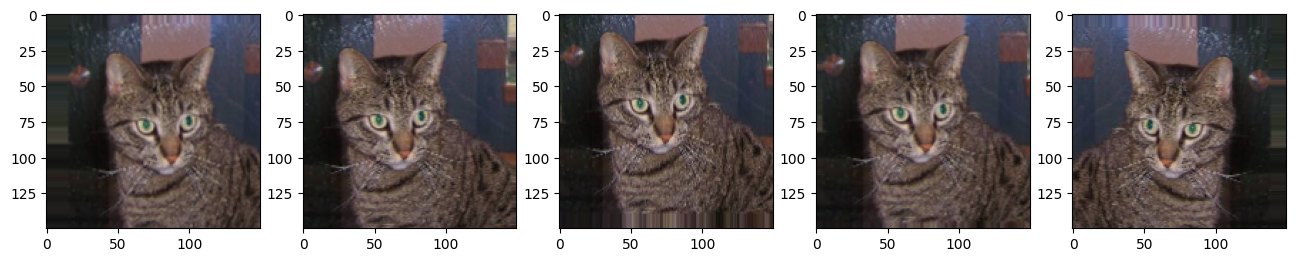

In [7]:
IMG_DIM = (150, 150)

train_files = glob.glob('./Cat-Dog-Dataset/training_set/cats/*')
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [".".join(fn.split('/')[3].split('.')[:-1]) for fn in train_files]
img_id = 0
cats_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
cats = [next(cats_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in cats])
l = [ax[i].imshow(cats[i][0][0]) for i in range(0,5)]

In [8]:
print(train_generator.class_indices)

{'cats': 0, 'dogs': 1}


Labels: ['dogs\\dog.1', 'dogs\\dog.1', 'dogs\\dog.1', 'dogs\\dog.1', 'dogs\\dog.1']


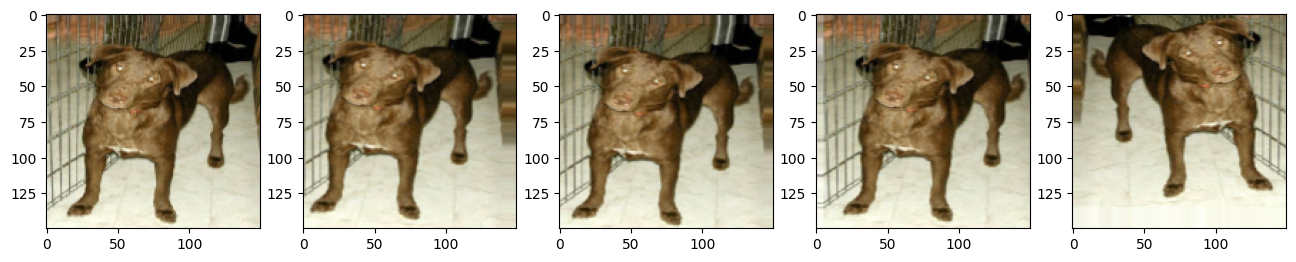

In [9]:
IMG_DIM = (150, 150)

train_files = glob.glob('./Cat-Dog-Dataset/training_set/dogs/*')
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [".".join(fn.split('/')[3].split('.')[:-1]) for fn in train_files]
img_id = 0
dogs_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
dogs = [next(dogs_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in dogs])
l = [ax[i].imshow(dogs[i][0][0]) for i in range(0,5)]


In [10]:
classifier = Sequential()
classifier.add(Conv2D(32, (5, 5), padding='same', input_shape = input_shape, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
classifier.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
classifier.add(Flatten())
classifier.add(Dense(units = 512, activation = 'relu'))
classifier.add(Dropout(0.3))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

In [11]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

In [13]:
classifier.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])

In [14]:
classifier.fit(
  train_generator,
  validation_data=val_generator,
  epochs=n_epochs
)

Epoch 1/10
101/101 [==============================] - 195s 2s/step - loss: 0.6822 - accuracy: 0.5540 - val_loss: 0.6759 - val_accuracy: 0.5659
Epoch 2/10
101/101 [==============================] - 194s 2s/step - loss: 0.6597 - accuracy: 0.6002 - val_loss: 0.6494 - val_accuracy: 0.6340
Epoch 3/10
101/101 [==============================] - 194s 2s/step - loss: 0.6426 - accuracy: 0.6252 - val_loss: 0.6368 - val_accuracy: 0.6271
Epoch 4/10
101/101 [==============================] - 196s 2s/step - loss: 0.6317 - accuracy: 0.6399 - val_loss: 0.6246 - val_accuracy: 0.6521
Epoch 5/10
101/101 [==============================] - 197s 2s/step - loss: 0.6148 - accuracy: 0.6602 - val_loss: 0.6110 - val_accuracy: 0.6533
Epoch 6/10
101/101 [==============================] - 192s 2s/step - loss: 0.6098 - accuracy: 0.6680 - val_loss: 0.6109 - val_accuracy: 0.6602
Epoch 7/10
101/101 [==============================] - 193s 2s/step - loss: 0.6021 - accuracy: 0.6765 - val_loss: 0.5952 - val_accuracy: 0.6821

In [16]:
# N = 10
# plt.style.use("ggplot")
# plt.figure()
# plt.plot(np.arange(0, N), classifier.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), classifier.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), classifier.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), classifier.history["val_accuracy"], label="val_acc")
# plt.title("Training Loss and Accuracy")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="center right")
     

In [18]:
classifier.save('classifier.h5')

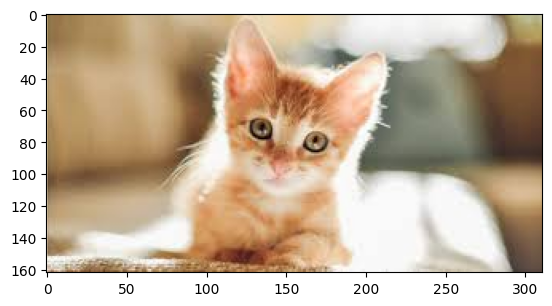

The image is a cat.


In [15]:
import numpy as np
from keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('classifier.h5')

# Load the image to be classified
img_path = 'cat_2.jpg'
img = Image.open(img_path)

# Display the input image
plt.imshow(img)
plt.show()

# Scale the image to the desired size
img = img.resize((150, 150))

# Convert the image to a numpy array
x = np.array(img)

# Reshape the array to a batch of size 1
x = x.reshape((1,) + x.shape)

# Normalize the pixel values (between 0 and 1)
x = x / 255.0

# Make a prediction
prediction = model.predict(x, verbose=0)

# Print the predicted class (0: cat, 1: dog)
if prediction[0] < 0.5:
    print("The image is a cat.")
else:
    print("The image is a dog.")



